<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext blackcellmagic

Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")

import os
import time
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple, List
from matplotlib import pyplot as plt

import torch
import numpy as np
import cv2
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import display_bounding_boxes
from utils_cv.detection.model import get_bounding_boxes, get_transform, get_pretrained_model
from utils_cv.detection.references.engine import train_one_epoch, evaluate
from utils_cv.detection.references.utils import collate_fn
from utils_cv.common.gpu import which_processor

which_processor()

Torch is using GPU: Tesla K80


This shows your machine's GPUs (if has any) and the computing device `torch/torchvision` is using. We suggest using an  [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6 as a GPU compute resource.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 3
LEARNING_RATE = 0.005
# IM_SIZE       = 300
# BATCH_SIZE    = 16
# ARCHITECTURE  = models.resnet18

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---

# Prepare Object Detection Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [4]:
path = Path(DATA_PATH)
os.listdir(path)

['images', 'annotations', '.DS_Store']

You'll notice that we have two different folders inside:
- `/images`
- `/annotations`

This format for object detection is fairly common.

```
/data
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- annotations
|   +-- image1.xml
|   +-- image2.xml
|   +-- ...
+-- ...
```

The xml files inside the annotation folder contain information on where the objects are the xml's corresponding image file. In this example, our fridge object dataset is annotated in Pascal VOC format. This is one of the most common formats for labelling object detection datasets.

```xml
<!-- Example Pascal VOC annotation -->
<annotation>
    <folder>images</folder>
    <filename>1.jpg</filename>
    <path>../images/1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>499</width>
        <height>666</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>

    <object>
        <name>carton</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>173</ymin>
            <xmax>233</xmax>
            <ymax>521</ymax>
        </bndbox>
    </object>
</annotation>
```

You'll notice that inside the annotation xml file, we can see which image the file references `<path>`, the number of `<objects>` in the image, that the image is of (`<name>`) and the bounding box of that object (`<bndbox>`).

# Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use. In short, we'll need to create a class and implement the `__getitem__` method. More information here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset

To make it more convinient, we've created a `DetectionDataset` class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class. 

In [26]:
fridge_objects_dataset = DetectionDataset(
    DATA_PATH, ["__background__", "can", "carton", "milk_bottle", "water_bottle"]
)

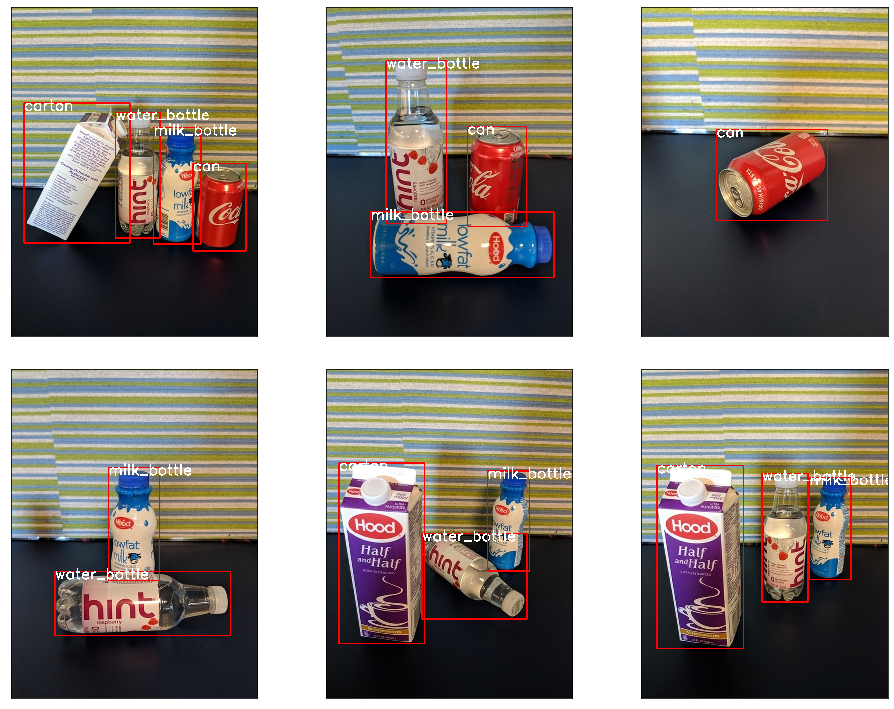

In [27]:
fridge_objects_dataset.show_batch(rows=2)

Now that we have our dataset setup, we want to split it into train/test sets, and then use them to create our data loaders which will be used when fine-tuning the model.

In [7]:
# split the dataset in train and test set
train_ds, test_ds = fridge_objects_dataset.split_train_test()

# define training and validation data loaders
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn
)

Lets make sure that the number of images in the training and testing set is what is expected.

In [9]:
print(f"""\
Training images: {len(train_ds)}
Testing images: {len(test_ds)}\
""")

Training images: 78
Testing images: 50


# Fine Tune a Pretrained Model

For this object detector, we use FasterRCNN, and Stochastic Gradient Descent as our optimizer. Our FasterRCNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

In [10]:
# get the model using our helper function
model = get_pretrained_model(len(fridge_objects_dataset.categories)).to(device)

# construct our optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

We can now fine-tune the model using our training data loader (`train_dl`) and evaluate our results using our testing data loader (`test_dl`).

In [11]:
for epoch in range(EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, test_dl, device=device)

Epoch: [0]  [ 0/39]  eta: 0:01:21  lr: 0.000136  loss: 1.6414 (1.6414)  loss_classifier: 1.4891 (1.4891)  loss_box_reg: 0.1391 (0.1391)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 2.0862  data: 0.2226  max mem: 2926
Epoch: [0]  [10/39]  eta: 0:00:43  lr: 0.001451  loss: 0.8122 (0.9331)  loss_classifier: 0.6010 (0.7775)  loss_box_reg: 0.1657 (0.1441)  loss_objectness: 0.0024 (0.0033)  loss_rpn_box_reg: 0.0088 (0.0082)  time: 1.4999  data: 0.0271  max mem: 3535
Epoch: [0]  [20/39]  eta: 0:00:27  lr: 0.002765  loss: 0.5611 (0.7473)  loss_classifier: 0.3834 (0.5697)  loss_box_reg: 0.1721 (0.1662)  loss_objectness: 0.0017 (0.0031)  loss_rpn_box_reg: 0.0077 (0.0083)  time: 1.4416  data: 0.0071  max mem: 3535
Epoch: [0]  [30/39]  eta: 0:00:13  lr: 0.004080  loss: 0.3440 (0.6006)  loss_classifier: 0.1626 (0.4307)  loss_box_reg: 0.1617 (0.1579)  loss_objectness: 0.0013 (0.0031)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 1.4428  data: 0.0065  max mem: 3535
Epoch: [

### Inference

In [12]:
# select image
im_path = test_ds.dataset.root/'images'/test_ds.dataset.ims[randrange(len(test_ds))]
im = Image.open(im_path)

# Define PyTorch Transform
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transform to the image
im = transform(im).cuda()

In [13]:
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    start = time.time()
    pred = model([im])
    print(f"Time spend: {time.time() - start}")

Time spend: 0.3500211238861084


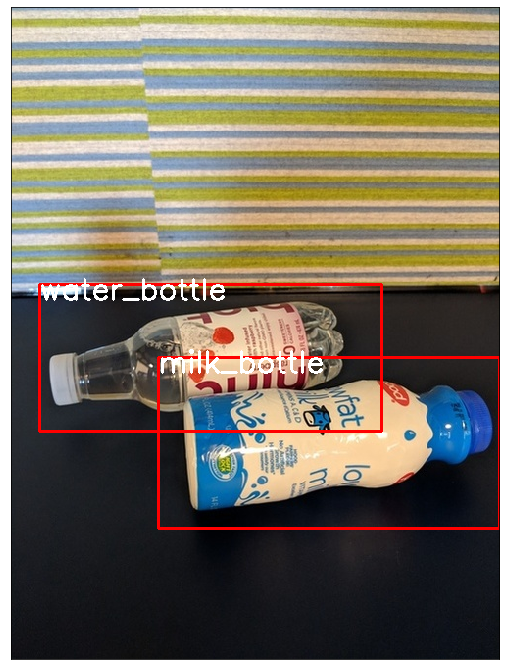

In [14]:
pred_labels, pred_boxes = get_bounding_boxes(pred)
display_bounding_boxes(pred_boxes, [fridge_objects_dataset.categories[l] for l in pred_labels], im_path)

In [15]:
fridge_objects_dataset.categories

['carton', 'milk_bottle', '__background__', 'water_bottle', 'can']